## 기본 셋팅

In [1]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,179 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline

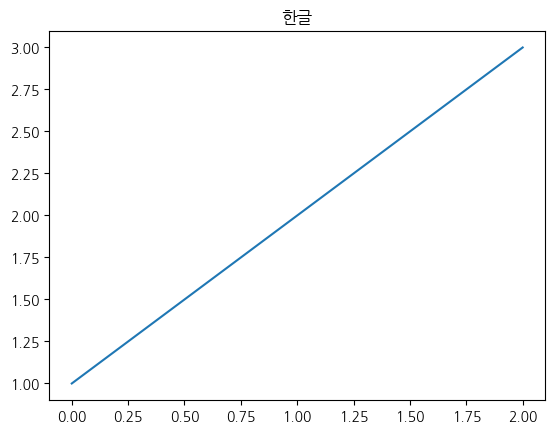

In [4]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import lightgbm
lightgbm.__version__

'3.3.2'

## Step0. 라이브러리 불러오기

In [12]:
from ast import increment_lineno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)


## Step 1. 데이터 불러오기

In [9]:
bike_df = pd.read_csv("/content/drive/MyDrive/멀티캠퍼스/machine learning/data/bike_train.csv")
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [10]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


## Step 02. 데이터가공 & EDA

In [11]:
drop_columns = ['datetime', 'casual','registered']
bike_df.drop(drop_columns,axis =1, inplace = True)

bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


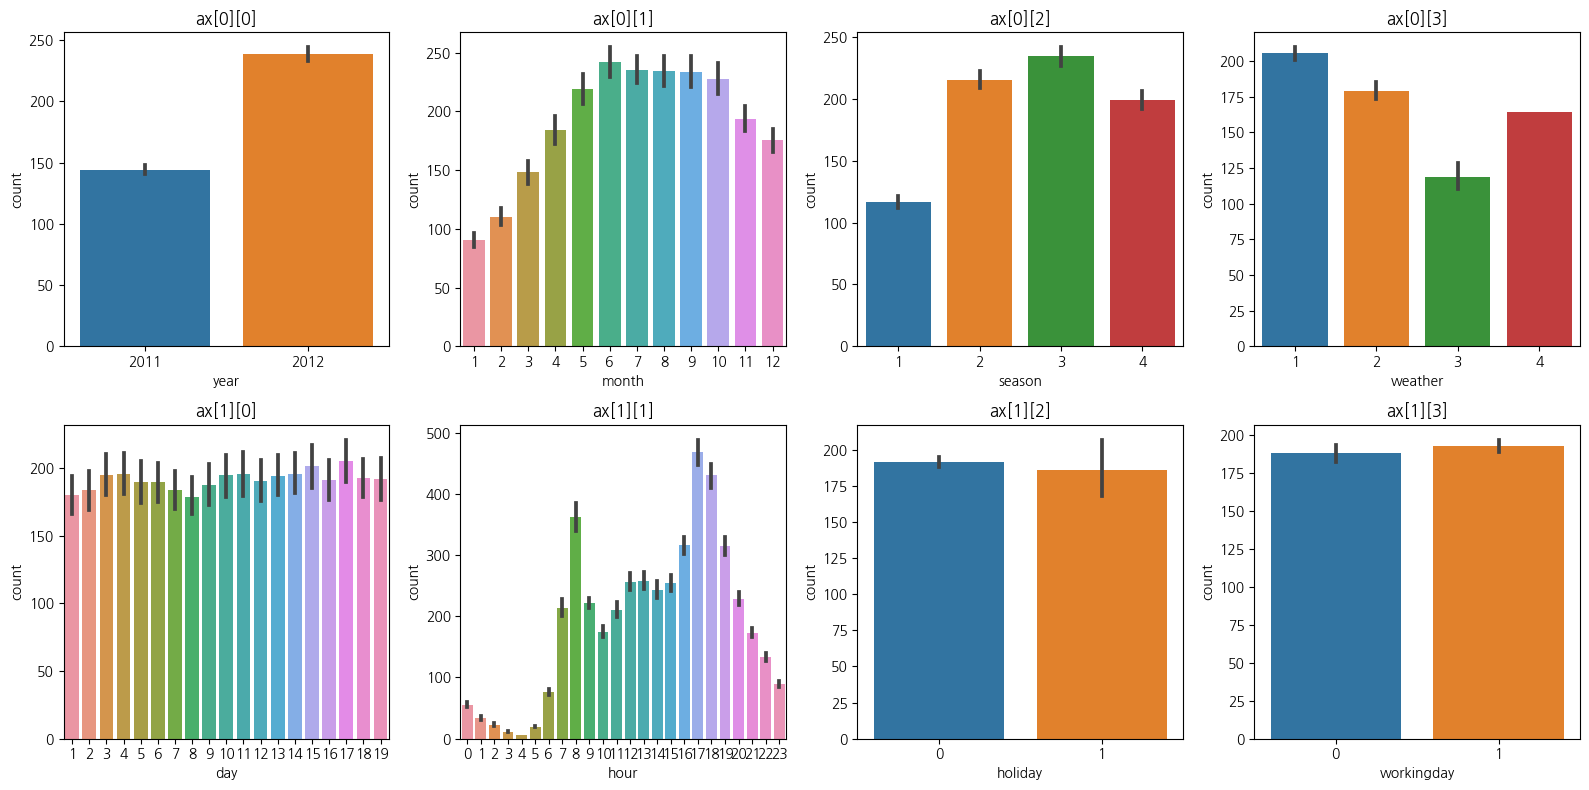

In [14]:
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
fig, ax = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
  row = int(i/4) # (몫 : 행을 4로 분화, 0과 1만나옴)
  col = i%4 # (나머지: 0,1,2,3 나옴)
  sns.barplot(x=feature ,y='count',data=bike_df,ax=ax[row][col])
  ax[row][col].set_title(f"ax[{row}][{col}]")

plt.tight_layout()
plt.show()

## Step 03. 평가지표 구현
- RMSLE : scilit-learn에서는 미 제공
- RMSLE 함수를 만듬

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환시 NAN등의 이슈로 log()가 아닌 log1p()을 이용해 RMSLE 계산
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y -log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

# MES, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
  rmsle_val=rmsle(y,pred)
  rmse_val=rmse(y,pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## Step 04. 로그 변환, 피처 인코딩, 모델 학습

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso

# 정규화, 표준화 작업 선 진행 해줘야함
y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train,X_test,y_train, y_test = train_test_split(X_features,y_target,test_size=0.3, random_state=0)

# X_train.shape, X_test.shape,y_train.shape,y_test.shape

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


## Step 05. 모델 평가

In [20]:
def get_top_error_data(y_test,pred,n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수와 예측값을 서로 비교할 수 있도록 생성.
  result_df = pd.DataFrame(y_test.values,columns = ['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] =np.abs(result_df['real_count']-result_df['predicted_count'])

  # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

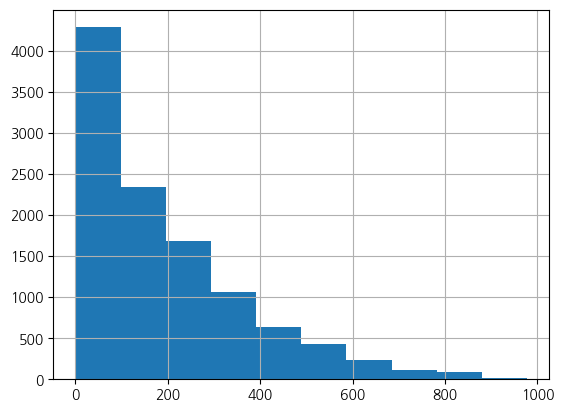

In [21]:
y_target.hist()

## Step 06. 종속변수 로그 변환

<Axes: >

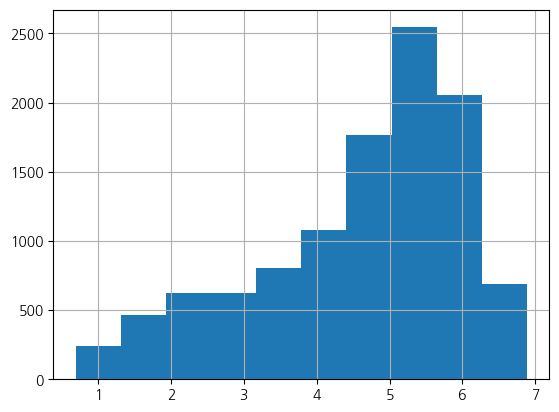

In [23]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

## Step 07. 모델 재구축

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso

# 정규화, 표준화 작업 선 진행 해줘야함
y_target_log = np.log1p(y_target)
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train,X_test,y_train, y_test = train_test_split(X_features,y_target_log,test_size=0.3, random_state=0)

# X_train.shape, X_test.shape,y_train.shape,y_test.shape

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- 각 피처의 회귀 계수 값 시각화

<Axes: >

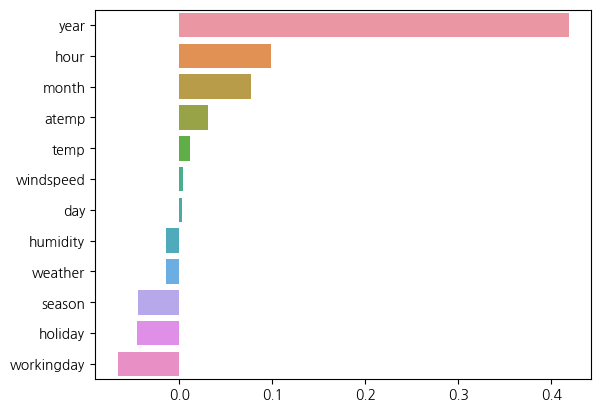

In [28]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## Step 08. 변수 인코딩 변환


In [33]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

## Step09. 모델 재구축2
- 기존 인코딩 변환
- 3개의 모델을 비교 분석 하겠다.

종속변수를 로그 변환으로 만든 후 예측했으면 평가진행할 땐 다시 원래데로 변환

In [34]:
# 테스트 / 훈련 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X_features_ohe, y_target_log,
                                                 test_size=0.3, random_state=0)
def get_model_predict(model, X_train, X_test,y_train,y_test,is_expm1=False):# 지수변환
   model.fit(X_train,y_train)
   pred=model.predict(X_test)
   if is_expm1: # 지수변환요청
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
   print('###',model.__class__.__name__,'###')
   evaluate_regr(y_test,pred)

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- 상위 20개 피처 찍어보기

<Axes: >

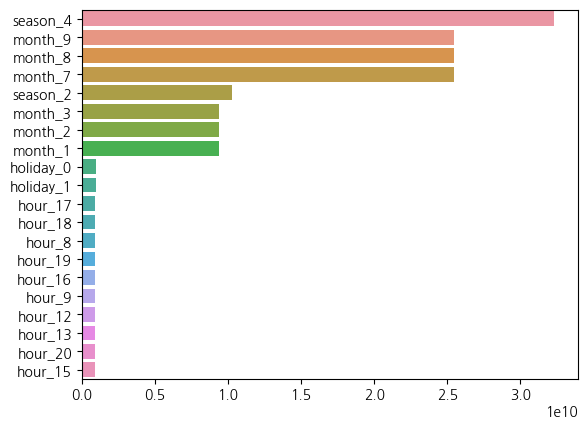

In [35]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

## step 10. 모델 재구축 3

In [36]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.259, MAE: 31.144
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.336, MAE: 32.744
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
